In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468277,72.528597,71.223274,71.476615,135480400
2020-01-03,71.763733,72.523762,71.539345,71.696175,146322800
2020-01-06,72.335556,72.374162,70.634539,70.885472,118387200
2020-01-07,71.995377,72.600983,71.775811,72.345227,108872000
2020-01-08,73.153488,73.455087,71.698574,71.698574,132079200
...,...,...,...,...,...
2025-11-21,271.489990,273.329987,265.670013,265.950012,59030800
2025-11-24,275.920013,277.000000,270.899994,270.899994,65585800


In [7]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [8]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.885528
2020-01-03,-1.900155
2020-01-06,-1.888284
2020-01-07,-1.895346
2020-01-08,-1.871303
...,...
2025-11-21,2.246183
2025-11-24,2.338150
2025-11-25,2.359948


In [9]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)


In [10]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
Y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
Y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [11]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [12]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
num_epochs=200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, Y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6515200138092041
25 0.013570215553045273
50 0.005608400329947472
75 0.0050264750607311726
100 0.004699708893895149
125 0.004421859048306942
150 0.004164402838796377
175 0.003926393575966358


In [15]:
model.eval()

y_train_pred = model(X_train)
y_test_pred = model(X_test)

y_train_pred_inv = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
Y_train_inv = scaler.inverse_transform(Y_train.detach().cpu().numpy())

y_test_pred_inv = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
Y_test_inv = scaler.inverse_transform(Y_test.detach().cpu().numpy())


In [16]:
train_rmse = np.sqrt(mean_squared_error(Y_train_inv[:, 0], y_train_pred_inv[:, 0]))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv[:, 0], y_test_pred_inv[:, 0]))

In [17]:
train_rmse

2.9342337

In [18]:
test_rmse

8.145816

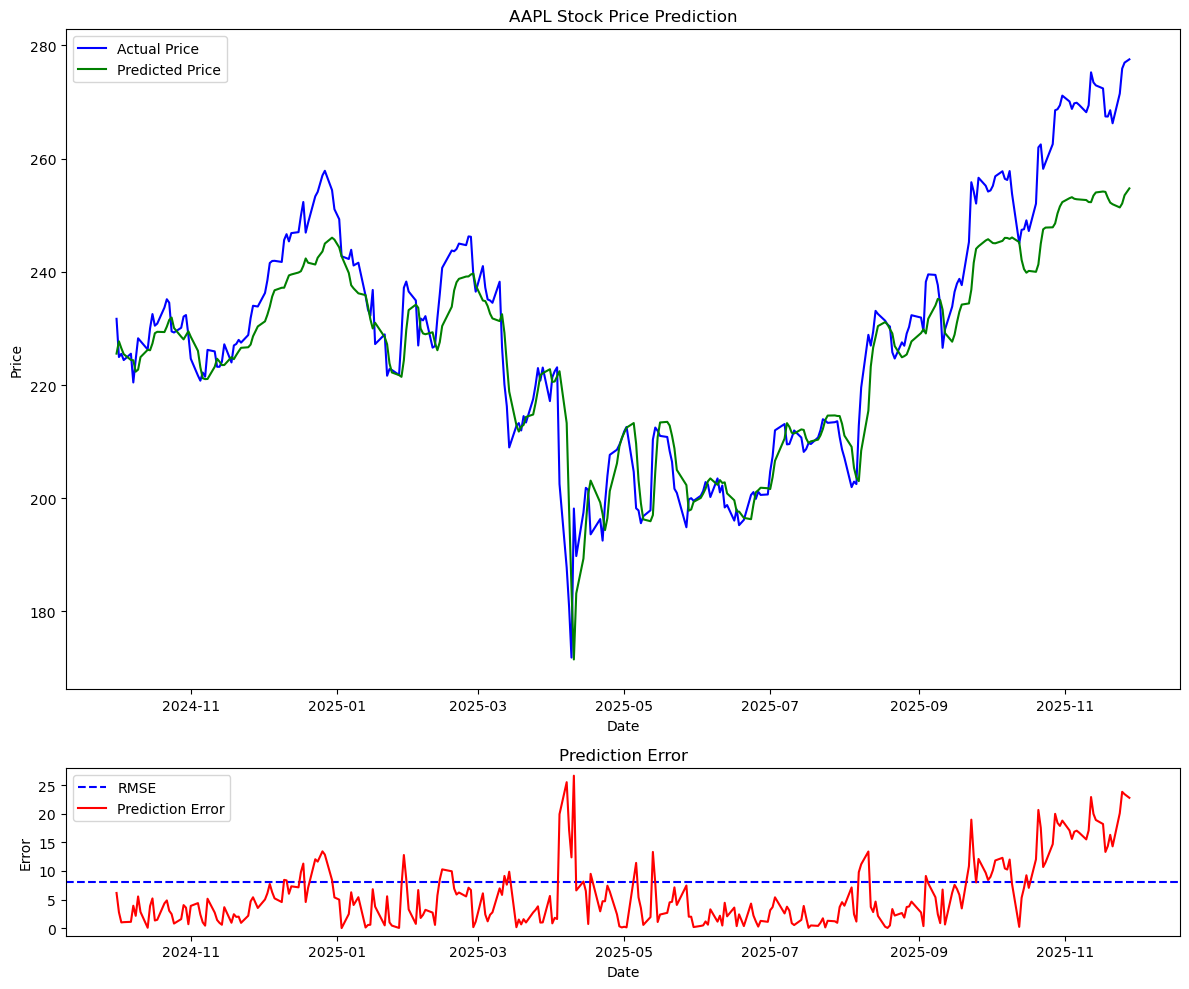

In [19]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(Y_test_inv):].index, Y_test_inv, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(Y_test_inv):].index, y_test_pred_inv, color='green', label='Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')
ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df.iloc[-len(Y_test_inv):].index, np.abs(Y_test_inv - y_test_pred_inv), 'r', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()
